In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
n_samples = 4000
n_components = 6

X, y  = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)

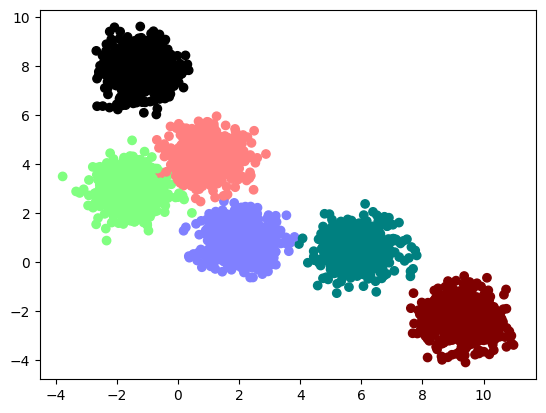

In [10]:
col = np.array([(1,0.5,0.5),(0.5,.5, 1),(0.5,1, .5),(0,0,0),(.5,0,0),(0,.5,.5)])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], color = col[y]);

In [32]:
class dnn_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin_1 = nn.Linear(in_features=2, out_features=20, bias=True)
    self.lin_2 = nn.Linear(in_features=20, out_features=6, bias=True)
    self.relu = nn.ReLU()
    self.soft_max  = nn.Softmax(dim=1)

  def forward(self,X : torch.tensor) -> torch.tensor:
    return self.soft_max(self.lin_2(self.relu(self.lin_1(X))))

In [11]:
X = torch.from_numpy(X).type(torch.float32)
labels_tensor = torch.as_tensor(y)
y = nn.functional.one_hot(labels_tensor, num_classes = n_components)
y = y.type(torch.float32)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123)

X_train = X_train.to(device)
X_test  = X_test.to(device)
y_train = y_train.to(device)
y_test  = y_test.to(device)

In [34]:
torch.manual_seed(12345)
dnn_mod = dnn_model()

In [35]:
lr      = 0.1
opt     = torch.optim.SGD(dnn_mod.parameters(),lr= lr)
loss_fn = torch.nn.BCELoss()

In [36]:
n_epochs   = 5000
accuracy   = []
loss_train = []
loss_test  = []
epoch_num  = []

for epoch in range(n_epochs):
    dnn_mod.train()
    y_pred   = dnn_mod(X_train)
    loss_tr  = loss_fn(y_pred, y_train)

    opt.zero_grad()
    loss_tr.backward()
    opt.step()
    
    if (epoch%10 ==0):
      dnn_mod.eval()
      with torch.inference_mode():
          y_pred_test = dnn_mod(X_test)

          loss_tst  = loss_fn(y_pred_test, y_test)
          loss_test.append(loss_tst.detach().item())
          loss_train.append(loss_tr.detach().item())
          accuracy.append(accuracy_score(torch.round(y_pred_test).detach().numpy(), y_test.numpy()))
          epoch_num.append(epoch)

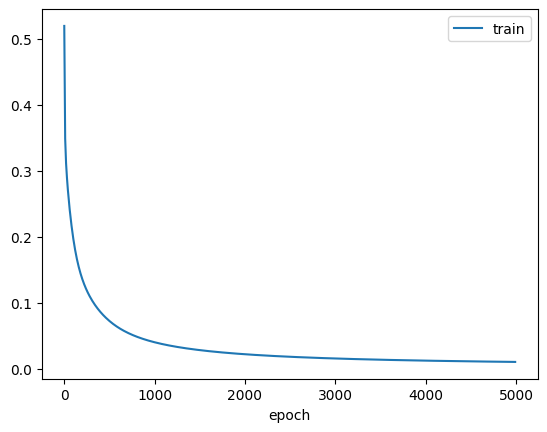

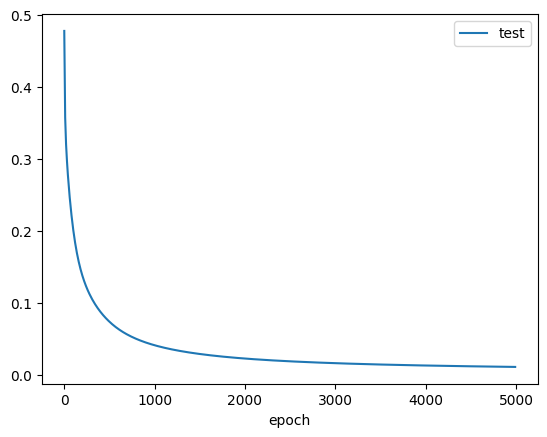

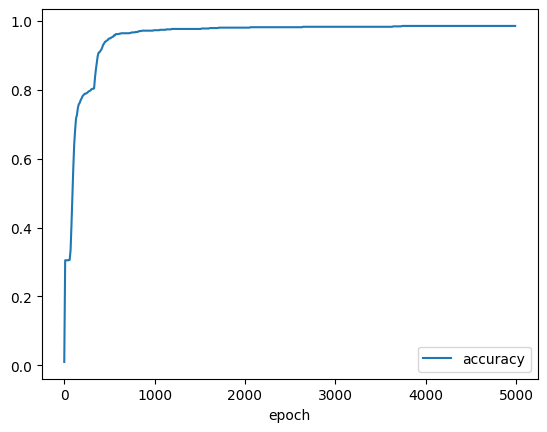

In [37]:
fig, ax = plt.subplots()
ax.plot(epoch_num, loss_train, label= 'train')
ax.set_xlabel('epoch')
ax.legend()

fig, ax = plt.subplots()
ax.plot(epoch_num, loss_test, label= 'test')
ax.set_xlabel('epoch')
ax.legend()

fig, ax = plt.subplots()
ax.plot(epoch_num, accuracy, label= 'accuracy')
ax.set_xlabel('epoch')
ax.legend()


In [38]:
#  boundaries
XX, YY  = np.meshgrid(np.arange(-5, 10, .1), np.arange(-5, 10, 0.1))

In [39]:
col_pred = []
with torch.inference_mode():
  for x_t, y_t in zip(XX.ravel(), YY.ravel()):
      X_temp = torch.tensor([[x_t,y_t]], dtype = torch.float32)
      col_pred.append(np.argmax(np.round((dnn_mod(X_temp).detach().numpy())).squeeze()))

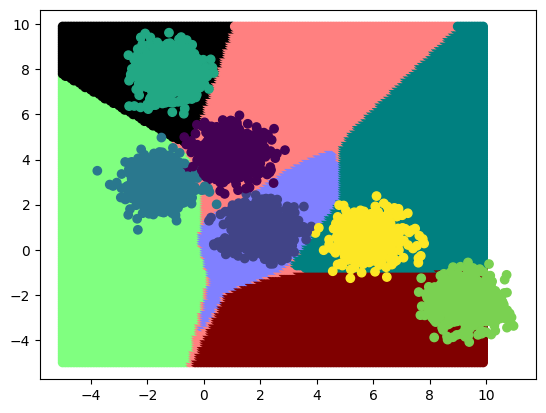

In [42]:
X_c, y_c  = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)

fig, ax = plt.subplots()
ax.scatter(XX.ravel(), YY.ravel(), c = col[col_pred])
ax.scatter(X_c[:,0], X_c[:,1], c = y_c)

In [43]:
 with torch.inference_mode():
      y_pred_test = dnn_mod(X_test)

In [44]:
def acc_by_cat(y_pred, y_test):
    cat_gt   = torch.argmax(y_test, dim=1).numpy()
    cat_pred = torch.argmax(y_pred_test, dim=1).numpy()
    cats     = np.unique(cat_gt)
    acc_cat  = np.zeros(len(cats))
    for u in range(len(cats)):
      cat_temp = cats[u]
      cat_gt_t = cat_gt[cat_gt == cat_temp]
      cat_pr   = cat_pred[cat_gt == cat_temp]
      acc_cat[u] = np.mean(cat_gt_t == cat_pr)

    return acc_cat

In [45]:
acc_by_cat(y_pred, y_test)

array([0.97080292, 1.        , 0.98601399, 1.        , 0.98461538,
       0.99310345])